# Single-channel Convolutional Sparse Coding

This notebook demonstrates the use of SPORCO to solve a convolutional sparse coding problem with a greyscale signal

$$\mathrm{argmin}_\mathbf{x} \; \frac{1}{2} \left\| \sum_m \mathbf{d}_m * \mathbf{x}_{m} - \mathbf{s} \right\|_2^2 + \lambda \sum_m \| \mathbf{x}_{m} \|_1$$

where $\mathbf{d}_{m}$ is the $m^{\text{th}}$ dictionary filter, $\mathbf{x}_{m}$ is the coefficient map corresponding to the $m^{\text{th}}$ dictionary filter, and $\mathbf{s}$ is the input image.



Import modules and configure matplotlib output to notebook.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco import util
from sporco import plot
import sporco.metric as sm
from sporco.admm import cbpdn

%matplotlib inline

Load test image and compute lowpass and highpass components.

In [2]:
# Load test image
img = util.rgb2gray(util.ExampleImages().image('kodim23', scaled=True)[160:416,60:316])

# Highpass filter test image
npd = 16
fltlmbd = 10
sl, sh = util.tikhonov_filter(img, fltlmbd, npd)

Load colour dictionary and display it.

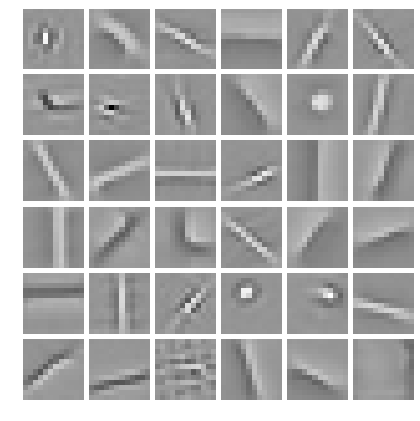

In [3]:
# Load dictionary
D = util.convdicts()['G:12x12x36']

# Display dictionary
fig = plot.figure(figsize=(7,7))
fgax = plot.imview(util.tiledict(D), fgrf=fig)

Set CBPDN solver class options.

In [4]:
# Set up ConvBPDN options
lmbda = 5e-2
opt = cbpdn.ConvBPDN.Options({'Verbose' : True, 'MaxMainIter' : 200,
                              'LinSolveCheck' : True, 'RelStopTol' : 5e-3,
                              'AuxVarObj' : False})

Initialise and run CBPDN solver and then reconstruct image from sparse representation.

In [5]:
# Solve CBPDN problem
b = cbpdn.ConvBPDN(D, sh, lmbda, opt, dimK=0)
X = b.solve()

print("ConvBPDN solve time: %.2fs" % b.runtime)

# Reconstruct representation
shr = b.reconstruct().squeeze()
imgr = sl + shr
print("Reconstruction PSNR: %.2fdB\n" % sm.psnr(img, imgr))

Itn   Fnc       DFid      Regℓ1     r         s         ρ         
----------------------------------------------------------------
   0  7.29e+01  8.03e-01  1.44e+03  8.61e-01  2.50e-01  3.50e+00
   1  5.98e+01  3.39e+00  1.13e+03  4.81e-01  4.19e-01  3.50e+00
   2  6.36e+01  3.81e+00  1.20e+03  3.21e-01  2.78e-01  3.15e+00
   3  5.73e+01  3.83e+00  1.07e+03  2.69e-01  2.05e-01  2.84e+00
   4  4.97e+01  4.12e+00  9.12e+02  2.27e-01  1.51e-01  2.84e+00
   5  4.67e+01  4.49e+00  8.45e+02  1.84e-01  1.13e-01  2.84e+00
   6  4.42e+01  4.73e+00  7.89e+02  1.44e-01  9.63e-02  2.84e+00
   7  4.19e+01  4.84e+00  7.42e+02  1.17e-01  8.34e-02  2.84e+00
   8  4.08e+01  4.89e+00  7.18e+02  9.80e-02  7.33e-02  2.84e+00
   9  3.93e+01  4.94e+00  6.88e+02  8.46e-02  6.20e-02  2.84e+00
  10  3.74e+01  5.01e+00  6.48e+02  7.33e-02  5.47e-02  2.84e+00
  11  3.60e+01  5.10e+00  6.18e+02  6.33e-02  5.07e-02  2.84e+00
  12  3.50e+01  5.16e+00  5.97e+02  5.55e-02  4.52e-02  2.84e+00
  13  3.43e+01  5.21e+0

Display low pass component and sum of absolute values of coefficient maps of highpass component.

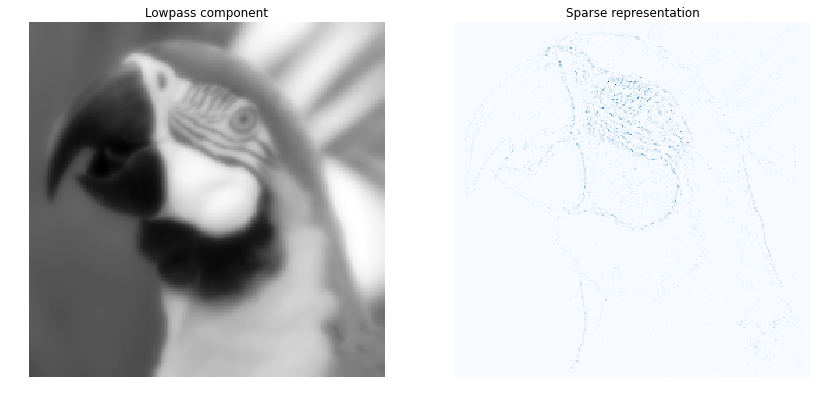

In [6]:
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(sl, title='Lowpass component', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(np.sum(abs(X), axis=b.cri.axisM).squeeze(), cmap=plot.cm.Blues,
            title='Sparse representation', fgrf=fig)

Display original and reconstructed images.

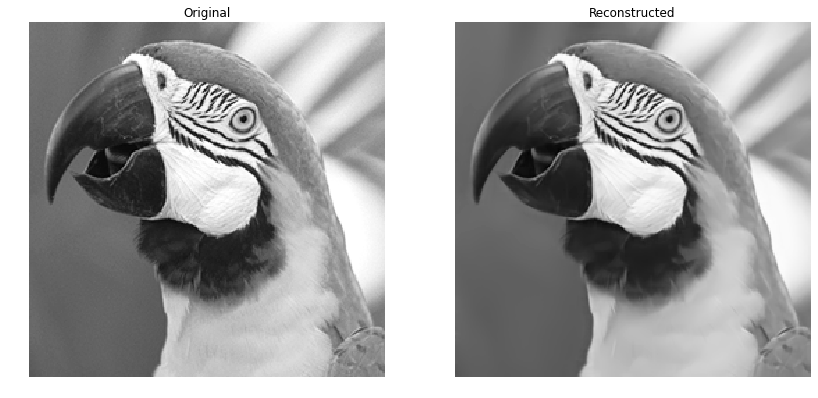

In [7]:
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(img, title='Original', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(imgr, title='Reconstructed', fgrf=fig)

Plot functional evolution during ADMM iterations.

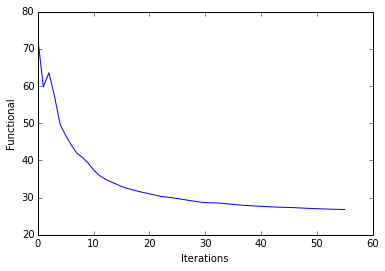

In [8]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')
plot.close()

Plot evolution of ADMM residuals and ADMM penalty parameter.

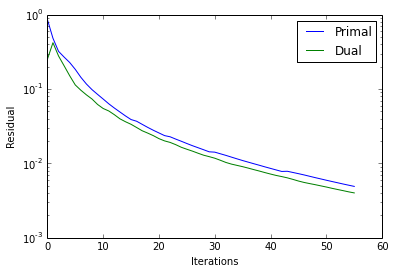

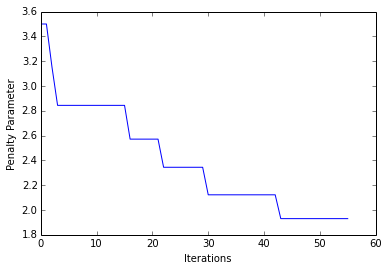

In [9]:
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual']);
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')
plot.close()